# Analyzing Franz Kafka's _The Metamorphosis_ with NLP

* Kafka's _Metamorphosis_ is commonly interpreted by humans as giving insights into the meaning of personal identity
* The conclusions that we can draw from texts are limited by our uniquely human preconceptions and rhetorical weaknesses
* Guiding question: What happens when computers read philosophy? That is, if we apply machine learning and linguistic approaches from natural language processing (NLP) to analyzing _The Metamorphosis_, how will the results support or contrast with our human reading?
* Read on to see what computers think about Kafka...

First, import the libraries that will be helpful later on.

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import random
import collections
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import functools
import os
import time
import numpy as np
np.random.seed(0)
import regex as re
import pandas as pd
from matplotlib import pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.set_option('display.max_colwidth', -1)
nltk.download('vader_lexicon')

/Applications/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jenniferjohn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The text is sourced from Project Gutenberg (David Wyllie
 translation): http://www.gutenberg.org/files/5200/5200-h/5200-h.htm.

In [1]:
file = open("texts/5200-h.txt", "r")
content = file.read()

Clean messy string into individual word tokens with some regex magic.

In [6]:
words = re.findall(r'\w+', content)

In [7]:
random.sample(words, 15)

['people',
 'himself',
 'They',
 'there',
 'a',
 'up',
 'made',
 'father',
 'had',
 'after',
 'up',
 'panting',
 'with',
 'been',
 'of']

In [8]:
len(words)

22383

Lots of words!

## Word frequencies

Count how many times each word occurs. Words are converted to lowercase to simplify things.

In [9]:
def get_word_freqs(words):
    freqs = {}
    for word in words:
        lower = word.lower()
        if lower in freqs:
            freqs[lower] += 1
        else:
            freqs[lower] = 1
    return freqs

In [10]:
word_freqs_dict = get_word_freqs(words)

Convert the dictionary of frequencies to a Pandas Series (nicer for lots of data). Note that there are far fewer unique than total words.

In [11]:
word_freqs = pd.Series(word_freqs_dict)
len(word_freqs)

2578

The 30 most frequently occurring words. By far the most common word is "the", which isn't surprising given its grammatical importance. In fact, most of these words aren't specific to _The Metamorphosis_. Interestingly, "room" appears more often even than generally common words "be" and "could", which suggests its significance in the story.

In [12]:
word_freqs.nlargest(30)

the       1148
to        753 
and       642 
he        590 
his       550 
of        429 
was       409 
it        370 
had       352 
in        348 
that      345 
gregor    298 
a         285 
as        242 
she       200 
with      199 
s         194 
him       188 
her       187 
would     187 
not       176 
but       171 
at        169 
for       166 
they      160 
on        152 
all       135 
room      131 
be        119 
could     119 
dtype: int64

Since many of these words aren't very interesting, let's forget about them for now. These words are called <a href="https://en.wikipedia.org/wiki/Stop_words" target="_blank">stop words</a>, and the NLP library NLTK conveniently includes a list of them so we can exclude them.

Some example stop words. Some may be word fragments due to how NLTK parses words.

In [13]:
stop_words = set(stopwords.words('english'))
random.sample(stop_words, 10)

['by',
 'from',
 've',
 'ours',
 'our',
 "weren't",
 'between',
 'are',
 "wasn't",
 'no']

Yay, that annoying "the" will be gone!

In [14]:
'the' in stop_words

True

Exclude the stop words to create a new series with only the salient words. Now the most common words are actually meaningful! We see the main character names at the top: Gregor and his father, sister, and mother. "Grete" doesn't appear on the list at all, reflecting Kafka's tendency to describe her in relation to Gregor (i.e. "his sister") rather than as her own character. That "room" appears at the top along with the important people suggests that it could be considered a character in itself: It plays an essential role in Gregor's development as he lives out his bug life, more so than any of his family members.

In [15]:
to_drop = [w for w in word_freqs.index if w in stop_words]
word_freqs_salient = word_freqs.drop(to_drop)
word_freqs_salient.nlargest(30)

gregor     298
would      187
room       131
could      119
father     102
sister     101
mother     89 
door       87 
back       82 
even       80 
one        72 
way        62 
time       59 
said       51 
little     49 
first      44 
get        44 
still      44 
go         40 
made       40 
see        39 
without    39 
head       38 
like       38 
much       38 
chief      37 
clerk      37 
open       35 
samsa      34 
away       32 
dtype: int64

## Word frequencies over time

Now that we've seen the patterns in word usage over the entire novella, let's see how they vary over time.

First get the positions of a given word throughout the text.

In [16]:
def get_word_indices(word):
    return [i for i,x in enumerate(words) if x == word]

For example, "picture" appears at these 6 positions. Five of these are clustered together in the section where Grete and the mother attempt to remove a picture from Gregor's rooom.

In [17]:
get_word_indices('picture')

[146, 13175, 13203, 13222, 13388, 13512]

Below is the frequency of "Gregor" over time. It tapers off at the end, after Gregor dies and the story turns to focus on his family. There's an interesting oscillating pattern, where "Gregor" alternately becomes frequent and infrequent.

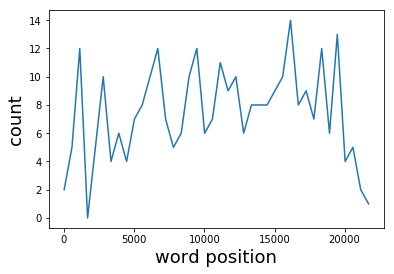

In [18]:
gregor_indices = get_word_indices('Gregor')
n, bins, _ = plt.hist(gregor_indices, bins=40)
plt.clf()
plt.plot(bins[:-1], n)
plt.xlabel('word position', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

Let's see how this compares to the mentions of Gregor's family members.

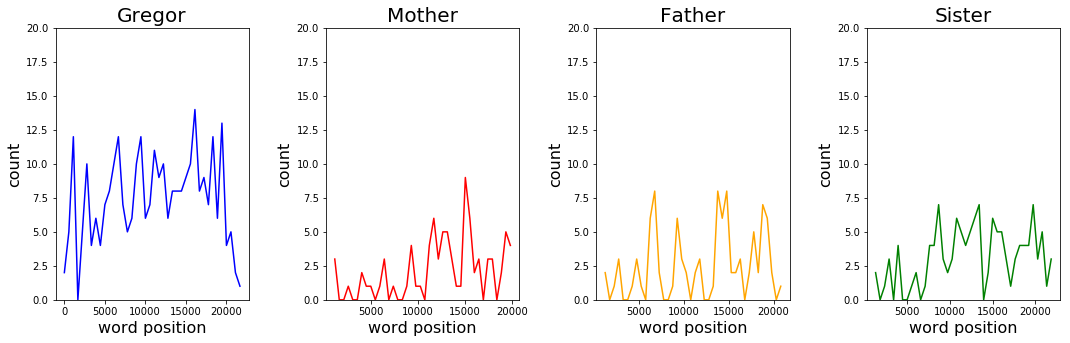

In [19]:
gregor_indices = get_word_indices('Gregor')
mother_indices = get_word_indices('mother')
father_indices = get_word_indices('father')
sister_indices = get_word_indices('sister') + get_word_indices('Grete')

n_gregor, bins_gregor, _ = plt.hist(gregor_indices, bins=40)
n_mother, bins_mother, _ = plt.hist(mother_indices, bins=40)
n_father, bins_father, _ = plt.hist(father_indices, bins=40)
n_sister, bins_sister, _ = plt.hist(sister_indices, bins=40)

plt.clf()

fig, ax = plt.subplots(nrows=1, ncols=4)

plt.subplots_adjust(wspace=0.4)
fig.set_figheight(5)
fig.set_figwidth(18)

ax[0].plot(bins_gregor[:-1], n_gregor, label="Gregor", color='blue');
ax[1].plot(bins_mother[:-1], n_mother, label='Mother', color='red');
ax[2].plot(bins_father[:-1], n_father, label='Father', color='orange');
ax[3].plot(bins_sister[:-1], n_sister, label='Sister', color='green');

chars = ['Gregor', 'Mother', 'Father', 'Sister']

for i in range(len(ax)):
    ax_i = ax[i]
    ax[i].set_title(chars[i], fontsize=20)
    ax[i].set_ylim([0, 20])
    ax[i].set_ylabel('count', fontsize=16)
    ax[i].set_xlabel('word position', fontsize=16)

plt.show()

As expected, Gregor is mentioned more often than any of his family members. The father takes on sudden importance around the 6,000th word, when he forces Gregor back into his room in front of the chief clerk. The mother gradually increases in importance until the mentions peak around the 15,000th word. At this point, Kafka turns to the lives of Gregor's family members as they adjust to their new predicament, with a focus on the mother's role.

The room varies in importance throughout the novella, with the most mentions when Kafka describes the family repurposing Gregor's room for storage, and the spatial relationship with the renters.

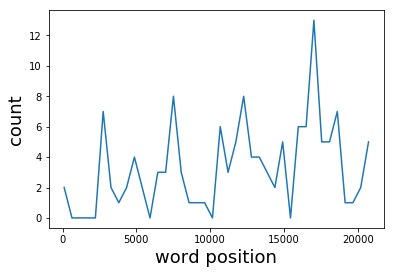

In [20]:
room_indices = get_word_indices('room')
n, bins, _ = plt.hist(room_indices, bins=40)
plt.clf()
plt.plot(bins[:-1], n)
plt.xlabel('word position', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

## Sentiment analysis

We can use machine learning to determine the sentiment of sentences throughout _The Metamorphosis_, quanitifying their predicted negative, neutral, and positive tones. 

For this task, I will use VADER (Valence Aware Dictionary and sEntiment Reasoner), an open-source tool trained on a combined dataset of Twitter tweets, New York Times editorials, Rotten Tomatoes movie reviews, and Amazon product reviews. See the <a href='https://github.com/cjhutto/vaderSentiment' target='_blank'>repository</a> for more information.

For simplicity, I'll use a pre-trained VADER model imported through NLTK.

In [21]:
analyzer = SentimentIntensityAnalyzer()

Let's see what it says for some example sentences:

In [22]:
analyzer.polarity_scores("Unlike Kafka, Hegel is not fun to read.")

{'compound': -0.4023, 'neg': 0.278, 'neu': 0.722, 'pos': 0.0}

This sentence is correctly assigned a higher negative score than positive (note that negative, neutral, and positive always sum to 1). The compound score is an overall metric ranging from -1 to +1, with -1 being the most negative and +1 being the most positive, so the negative compound score is in line with our expectations.

And for another simple example, the results also seem reasonable:

In [23]:
analyzer.polarity_scores("I'm really excited to read more Kafka!")

{'compound': 0.4561, 'neg': 0.0, 'neu': 0.668, 'pos': 0.332}

Now let's try it for the first few sentences of _The Metamorphosis_:

In [24]:
analyzer.polarity_scores("""
    One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.""")

{'compound': -0.5859, 'neg': 0.258, 'neu': 0.635, 'pos': 0.107}

Seems pretty negative to me.

In [25]:
analyzer.polarity_scores("""
    He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.""")

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

The model wasn't quite sure what to do with this one and labeled it as entirely neutral. That seems reasonable since the positivity or negativity of Gregor initially observing his bug body is open to interpretation.

In [26]:
analyzer.polarity_scores("""
    The bedding was hardly able to cover it and seemed ready to slide off any moment.""")

{'compound': 0.3612, 'neg': 0.0, 'neu': 0.857, 'pos': 0.143}

Interesting that this is predicted as more positive, although it's still closer to neutral.

In [27]:
analyzer.polarity_scores("""
    His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked.
    """)

{'compound': -0.5574, 'neg': 0.204, 'neu': 0.796, 'pos': 0.0}

This one is pretty clearly negative.

To run a sentiment analysis over the entire text, it first needs to be divided into sentences.

In [216]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = tokenizer.tokenize(content)


Find the sentiment (compound, negative, neutral, and positive scores) for each sentence.

In [29]:
sentiments = [analyzer.polarity_scores(sentence) for sentence in sentences]
compound_scores = [sentiment['compound'] for sentiment in sentiments]
neg_scores = [sentiment['neg'] for sentiment in sentiments]
neu_scores = [sentiment['neu'] for sentiment in sentiments]
pos_scores = [sentiment['pos'] for sentiment in sentiments]

First, let's look at the compound score.

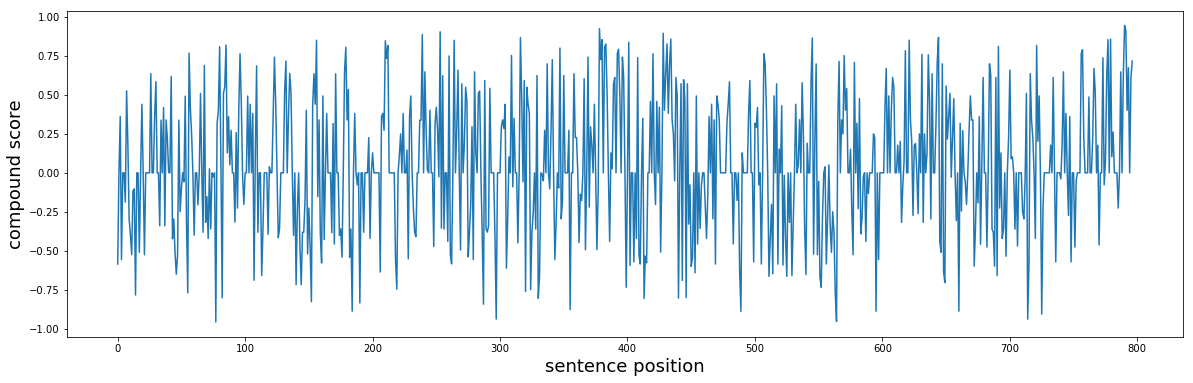

In [30]:
plt.figure(figsize=(20,6))
plt.ylabel('compound score', fontsize=18)
plt.xlabel('sentence position', fontsize=18)
plt.plot(compound_scores)
plt.show()

There doesn't seem to be much of a pattern here. That's not too surprising due to a few factors:
1. By only taking 1 sentence into account at a time, this model misses out on the contextual information of the surrounding sentences, so its ability to determine positivity and negativity is limited.
2. The novella could be interpreted as having intentional alternating emotional highs and lows. Each setback Gregor experiences is countered by an equal and opposite reaction in the form of discoveries about his new identity and victories over his physiological limits.

The sentiment of the last 50 or so sentences does seem to be decidedly positive, according to the graph. Looking at the text, this interpretation would take the perspective of Gregor's family members. With Gregor no longer in the picture, they can again enjoy the simple pleasures of life, like going for a walk and taking the tram. Here we thus see a limit of using a model like this one to analyze sentiment: It's only able to pick up on the emotions that are explicitly expressed, while the implied tragedy of Gregor's death goes unnoticed.

Now for the negative scores:

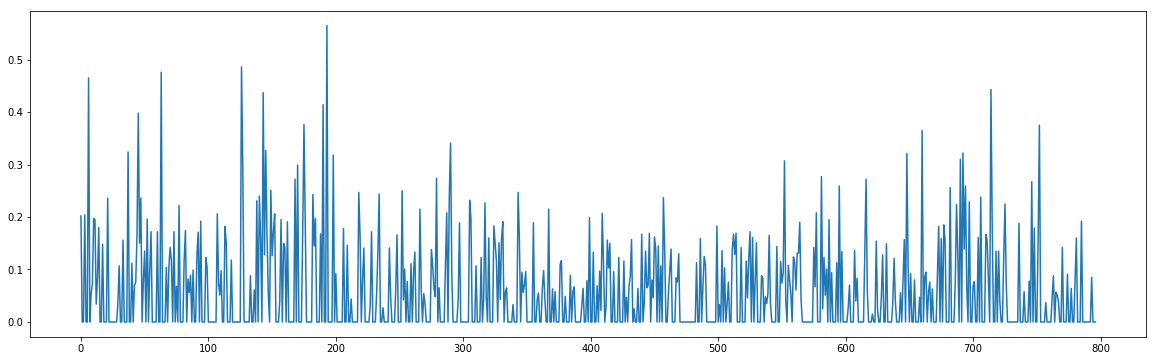

In [31]:
plt.figure(figsize=(20,6))
plt.plot(neg_scores)
plt.show()

The most strongly negative scenes seem to occur in the first and last 200 sentences. This pattern follows from Kafka's changing choice of focus in the novella. Initially, he presents Gregor's situation as decidedly negative, as he is overcome with the distress of his predicament. After having the body of an insect has become the new status quo to Gregor, the negativity is less pronounced. The story now focuses on Gregor's individual experiences as an insect, which are not necessarily negative, in contrast to the sudden shock of a new body. Nearing the end, there's a slight uptick in negativity, which correlates with Gregor's impending death.


Let's figure out which sentence has that big negative spike:

In [32]:
sentences[np.argmax(neg_scores)]

'she then cried.'

Ok, fair enough-- that's pretty clearly negative. Although it makes sense by itself, the negativity still holds in the larger context of that section of the text:

In [33]:
max_pos = np.argmax(neg_scores)
' '.join(sentences[max_pos-6:max_pos+1])

'"Did you understand a word of all that?" the chief clerk asked his parents, "surely he\'s not trying to make fools of us". "Oh, God!" called his mother, who was already in tears, "he could be seriously ill and we\'re making him suffer. Grete! Grete!" she then cried.'

Yep, this is definitely not a highlight for Kafka's characters.

And the top 10 most negative sentences:

In [34]:
neg_indices = np.argsort(neg_scores)[-10:][::-1]
for i in neg_indices:
    print(sentences[i], neg_scores[i])

she then cried. 0.565
"He isn't well, please believe me. 0.486
Aren't you well? 0.476
It wasn't a dream. 0.465
It is true that his entire body was aching, but the pain seemed to be slowly getting weaker and weaker and would finally disappear altogether. 0.443
And why was she crying? 0.437
called his mother, who was already in tears, "he could be seriously ill and we're making him suffer. 0.414
What about if he reported sick? 0.398
Please, don't make my parents suffer! 0.376
"Leave my home. 0.375


Most of these are pretty clearly negative, while others are more questionable. It's particularly interesting that "Aren't you well?" is scored so negatively. By itself, the question isn't necessarily negative, but in the context it definitely is: Grete is described as asking it of Gregor "plaintively."

Similarly interesting is the negative score predicted for "It wasn't a dream." Without the larger context of the storyline, that could be a positive statement, if the dream-like situation were pleasant. Here, however, it's negative, as the "dream" is waking up as an insect.

Now for the positive scores.

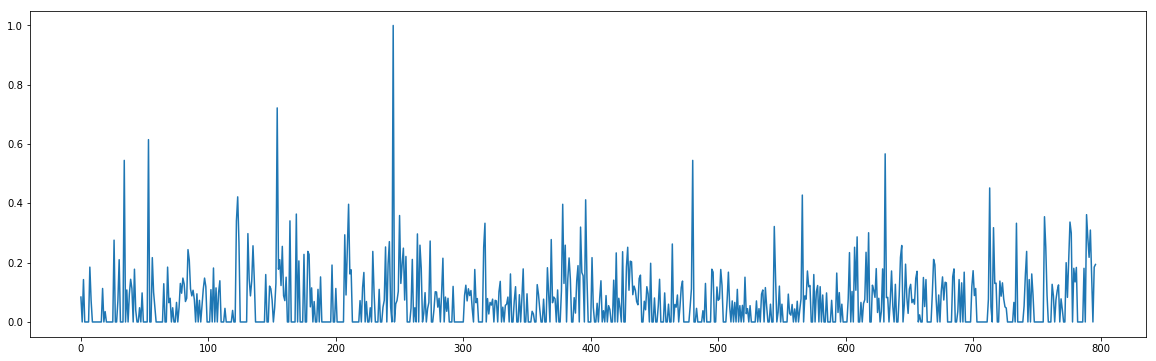

In [35]:
plt.figure(figsize=(20,6))
plt.plot(pos_scores)
plt.show()

Not too much of a pattern here, although of note is the really happy thing that seems to happen around sentence 240. Let's see what that is...

In [36]:
sentences[np.argmax(pos_scores)]

'Yes?'

Well, not quite positive in terms of tone, but that prediction could be justified with the fact that "yes" is technically a positive word by definition.

The most positive sentences:

In [37]:
pos_indices = np.argsort(pos_scores)[-10:][::-1]
for i in pos_indices:
    print(sentences[i], pos_scores[i])

Yes? 1.0
I am astonished, quite astonished. 0.722
That gentle voice! 0.615
Yet Gregor's sister was playing so beautifully. 0.567
Well, she could certainly try it! 0.545
"God in Heaven!" 0.545
He also felt relatively comfortable. 0.452
Gregor, on the other hand, ought not to be neglected. 0.428
I'm sure he'll be good enough to forgive the untidiness of your room." 0.422
His father was healthy but old, and lacking in self confidence. 0.412


We again see a mix of clearly reasonable predictions and more questionable but justifiable ones. Keeping in mind that the training dataset from this model included movie reviews, it seems more likely that one would declare their astonishment for a positive movie experience rather than negative, which explains the high positive prediction for the second sentence. For the most part, the other predictions are in line with our human reading.

Finally, the neutral scores:

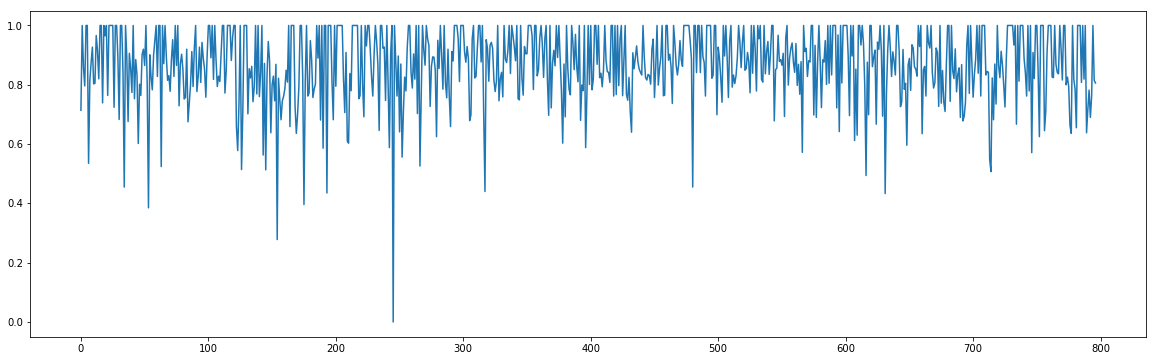

In [38]:
plt.figure(figsize=(20,6))
plt.plot(neu_scores)
plt.show()

This one looks like a vertical reflection of the other graph because neutrality dominates over positivity and negativity. That makes sense because most sentences by themselves don't reveal strong emotional directions. Note that the sentence with minimal neutrality (0) corresponds to the sentence with maximal positivity (1) because neutral, negative, and positive scores all sum to 1.

 Let's see how many sentences are 100% neutral:

In [39]:
np.count_nonzero(np.array(neu_scores) == 1.0)

238

In [50]:
one_indices = np.random.choice(np.where(np.array(neu_scores)==1.0)[0], 10)
for i in one_indices:
    print(sentences[i], neu_scores[i])

The dustbins from the kitchen found their way in there too. 1.0
Be patient! 1.0
That's to say, it was money that should not really be touched but set aside for emergencies; money to live on had to be earned. 1.0
Throughout all this, Gregor had lain still where the three gentlemen had first seen him. 1.0
Gregor slowly pushed his way over to the door with the chair. 1.0
I can't endure it any more." 1.0
"Am I less sensitive than I used to be, then? 1.0
For instance, whenever I go back to the guest house during the morning to copy out the contract, these gentlemen are always still sitting there eating their breakfasts. 1.0
", asked Mrs. Samsa, looking at the charwoman enquiringly, even though she could have checked for herself and could have known it even without checking. 1.0
Do you need anything?" 1.0


The only unambiguous mistake here is the classification of "I can't endure it any more," which seems pretty clearly dispairing. Otherwise, though, the predictions are right on target. None of the other sentences have obvious unilateral emotional implications.

Let's zoom in on the sentiment scores for two particularly significant scenes. First is the dramatic encounter between Gregor and his mother, which ends with the mother fainting and Gregor overcome with his powerlessness:

>But Grete's words had made her mother quite worried, she stepped to one side, saw the enormous brown patch against the flowers of the wallpaper, and before she even realised it was Gregor that she saw screamed: "Oh God, oh God!" Arms outstretched, she fell onto the couch as if she had given up everything and stayed there immobile. "Gregor!" shouted his sister, glowering at him and shaking her fist. That was the first word she had spoken to him directly since his transformation. She ran into the other room to fetch some kind of smelling salts to bring her mother out of her faint; Gregor wanted to help too - he could save his picture later, although he stuck fast to the glass and had to pull himself off by force; then he, too, ran into the next room as if he could advise his sister like in the old days; but he had to just stand behind her doing nothing; she was looking into various bottles, he startled her when she turned round; a bottle fell to the ground and broke; a splinter cut Gregor's face, some kind of caustic medicine splashed all over him; now, without delaying any longer, Grete took hold of all the bottles she could and ran with them in to her mother; she slammed the door shut with her foot. So now Gregor was shut out from his mother, who, because of him, might be near to death; he could not open the door if he did not want to chase his sister away, and she had to stay with his mother; there was nothing for him to do but wait; and, oppressed with anxiety and self-reproach, he began to crawl about, he crawled over everything, walls, furniture, ceiling, and finally in his confusion as the whole room began to spin around him he fell down into the middle of the dinner table.

This scene marks a turning point in the relationship between Gregor and his family. Having held out hope that Gregor's transformation would be reversible, the mother is forced to come to terms with the new reality of his exterior, and potentially its associated identity. She doesn't even see him as a living being anymore, let alone as her son--he has been reduced to an "enormous brown patch." This shift contrasts with Grete's continued recognition (or assumption) of Gregor's humanity. By addressing him by name, she connects the "enormous brown patch" to the brother she knows, validating his existence as a human trapped in an insect's body. That she scolds him is even more telling of the divergence with the mother's reaction. Blaming Gregor for scaring the mother implies that Gregor has control over the aspects of his appearance that caused her fright.

So what does NLP make of these complex themes?

In [41]:
turning_point = """But Grete's words had made her mother quite worried, she stepped to one side, saw the enormous brown patch against the flowers of the wallpaper, and before she even realised it was Gregor that she saw screamed: "Oh God, oh God!" Arms outstretched, she fell onto the couch as if she had given up everything and stayed there immobile. "Gregor!" shouted his sister, glowering at him and shaking her fist. That was the first word she had spoken to him directly since his transformation. She ran into the other room to fetch some kind of smelling salts to bring her mother out of her faint; Gregor wanted to help too - he could save his picture later, although he stuck fast to the glass and had to pull himself off by force; then he, too, ran into the next room as if he could advise his sister like in the old days; but he had to just stand behind her doing nothing; she was looking into various bottles, he startled her when she turned round; a bottle fell to the ground and broke; a splinter cut Gregor's face, some kind of caustic medicine splashed all over him; now, without delaying any longer, Grete took hold of all the bottles she could and ran with them in to her mother; she slammed the door shut with her foot. So now Gregor was shut out from his mother, who, because of him, might be near to death; he could not open the door if he did not want to chase his sister away, and she had to stay with his mother; there was nothing for him to do but wait; and, oppressed with anxiety and self-reproach, he began to crawl about, he crawled over everything, walls, furniture, ceiling, and finally in his confusion as the whole room began to spin around him he fell down into the middle of the dinner table."""

In [42]:
turning_pt_sents_temp = turning_point.split(';')
turning_pt_sents=[]
for x in turning_pt_sents_temp:
    turning_pt_sents.extend(x.split('.'))

In [43]:
turning_pt_table = pd.DataFrame(columns = ['text', 'neg', 'neu', 'pos', 'compound']) 

In [44]:
for i in range(len(turning_pt_sents)):
    sent = turning_pt_sents[i]
    turning_pt_table.loc[i] = [sent] + list(analyzer.polarity_scores(sent).values())

In [45]:
turning_pt_table

,text,neg,neu,pos,compound
0,"But Grete's words had made her mother quite worried, she stepped to one side, saw the enormous brown patch against the flowers of the wallpaper, and before she even realised it was Gregor that she saw screamed: ""Oh God, oh God!"" Arms outstretched, she fell onto the couch as if she had given up everything and stayed there immobile",0.080,0.886,0.033,-0.4561
1,"""Gregor!"" shouted his sister, glowering at him and shaking her fist",0.166,0.834,0.000,-0.2481
2,That was the first word she had spoken to him directly since his transformation,0.000,1.000,0.000,0.0000
3,She ran into the other room to fetch some kind of smelling salts to bring her mother out of her faint,0.000,1.000,0.000,0.0000
4,"Gregor wanted to help too - he could save his picture later, although he stuck fast to the glass and had to pull himself off by force",0.065,0.744,0.191,0.5994
5,"then he, too, ran into the next room as if he could advise his sister like in the old days",0.000,0.884,0.116,0.3612
6,but he had to just stand behind her doing nothing,0.000,1.000,0.000,0.0000
7,"she was looking into various bottles, he startled her when she turned round",0.124,0.876,0.000,-0.1779
8,a bottle fell to the ground and broke,0.318,0.682,0.000,-0.4215
9,"a splinter cut Gregor's face, some kind of caustic medicine splashed all over him",0.149,0.851,0.000,-0.2732


Looking in the right column containing the compound score, 2 sentences are rated as positive, 8 as negative, and 6 as neutral.

All of the negative classifications appear to be correct. Not only that, but the magnitude of the compound score for these negative sentences correlates with their degree of negativity. The description of Gregor's becoming overwhelmed and anxious is certainly more negative than Grete's scolding of him, which is reflected in the nearly three times greater compound score assigned to the description of anxiety.

The sentences classified as neutral are the most objective, and don't point obviously in one emotional direction. 

The 2 positive classifications raise interesting implications. The 4th sentence was assigned the highest compound rating, but also received both positive and negative scores. Whether the overall positive prediction is deserved  depends on the reader's interpretation. On the one hand, Gregor's determination to help his mother even as she refuses to see him as her son suggests a chance at reconciliation initiated by Gregor that could justify positivity. But balanced against that positivity is the negative reality of the limitations on Gregor's ability to help, symbolized by his sticking to the glass. Interestingly, the only other positive sentence also includes the theme of Gregor's determination to help. While this one hints at the newly imposed limitations on his helpfulness by referencing "the old days," it doesn't directly address the setbacks he now faces.

Now for another turning point in the novella, Gregor's death:
>"What now, then?", Gregor asked himself as he looked round in the darkness. He soon made the discovery that he could no longer move at all. This was no surprise to him, it seemed rather that being able to actually move around on those spindly little legs until then was unnatural. He also felt relatively comfortable. It is true that his entire body was aching, but the pain seemed to be slowly getting weaker and weaker and would finally disappear altogether. He could already hardly feel the decayed apple in his back or the inflamed area around it, which was entirely covered in white dust. He thought back of his family with emotion and love. If it was possible, he felt that he must go away even more strongly than his sister. He remained in this state of empty and peaceful rumination until he heard the clock tower strike three in the morning. He watched as it slowly began to get light everywhere outside the window too. Then, without his willing it, his head sank down completely, and his last breath flowed weakly from his nostrils.

This passage has been the subject of much debate and varied interpretation, as the abstract way in which Kafka describes Gregor's death raises questions about his intended implications. Was it Gregor himself who died, or just his insect exterior? If the latter, then what happened to Gregor's soul and identity--did they die with the exterior, or had they gradually faded earlier on in the story? While we'll never know what Kafka was thinking when he wrote this passage, we can come close by analyzing the emotions that he conveys. Without further ado, enter the NLP...

In [46]:
bye_gregor = """"What now, then?", Gregor asked himself as he looked round in the darkness. He soon made the discovery that he could no longer move at all. This was no surprise to him, it seemed rather that being able to actually move around on those spindly little legs until then was unnatural. He also felt relatively comfortable. It is true that his entire body was aching, but the pain seemed to be slowly getting weaker and weaker and would finally disappear altogether. He could already hardly feel the decayed apple in his back or the inflamed area around it, which was entirely covered in white dust. He thought back of his family with emotion and love. If it was possible, he felt that he must go away even more strongly than his sister. He remained in this state of empty and peaceful rumination until he heard the clock tower strike three in the morning. He watched as it slowly began to get light everywhere outside the window too. Then, without his willing it, his head sank down completely, and his last breath flowed weakly from his nostrils."""

In [47]:
bye_gregor_sents = bye_gregor.split('.')

bye_gregor_table = pd.DataFrame(columns = ['text', 'neg', 'neu', 'pos', 'compound']) 

for i in range(len(bye_gregor_sents)):
    sent = bye_gregor_sents[i]
    bye_gregor_table.loc[i] = [sent] + list(analyzer.polarity_scores(sent).values())

In [48]:
bye_gregor_table

,text,neg,neu,pos,compound
0,"""What now, then?"", Gregor asked himself as he looked round in the darkness",0.143,0.857,0.000,-0.2500
1,He soon made the discovery that he could no longer move at all,0.155,0.845,0.000,-0.2960
2,"This was no surprise to him, it seemed rather that being able to actually move around on those spindly little legs until then was unnatural",0.081,0.842,0.077,-0.0258
3,He also felt relatively comfortable,0.000,0.548,0.452,0.5106
4,"It is true that his entire body was aching, but the pain seemed to be slowly getting weaker and weaker and would finally disappear altogether",0.443,0.507,0.051,-0.9403
5,"He could already hardly feel the decayed apple in his back or the inflamed area around it, which was entirely covered in white dust",0.177,0.823,0.000,-0.5770
6,He thought back of his family with emotion and love,0.000,0.682,0.318,0.6369
7,"If it was possible, he felt that he must go away even more strongly than his sister",0.000,0.870,0.130,0.3384
8,He remained in this state of empty and peaceful rumination until he heard the clock tower strike three in the morning,0.135,0.735,0.131,0.2263
9,He watched as it slowly began to get light everywhere outside the window too,0.000,1.000,0.000,0.0000


The first difference to take note of here is the significantly smaller proportion of neutral sentences: only 1 out of 11. That points to the emotional complexity of the scene with which Kafka intended for us to grapple. Only as Gregor contemplates the changing light in the second to last sentence do we get a break from the emotional intensity.

Of the remaining 10 sentences, 6 are classified as negative and 4 as positive, indicating a marginally overall negative sentiment. That makes sense because regardless of whether it is Gregor himself or only the insect body that dies, with that death comes the irreversible fading of Gregor's existence from the world. Since Gregor has served as our effective protagonist, the loss of his voice is associated with negativity. The fluctuations between negative and positive compound scores also correlate with the alternating descriptions of Gregor's comfortable peace and recognition of painful loss.

## Sentence clustering

A common technique used in machine learning to gain insights into data is clustering. Given key features about a large number of data points, a machine learning model partitions the dataset into groups. This partitioning is defined to (roughly) maximize both the similarities within groups and differences between groups for a set of features. Clustering can be handy because it is an unsupervised algorithm, meaning that we don't need to know what classes we want to divide our data into. We just want to see the natural groupings within our data. In contrast, the sentiment analysis we just finished was supervised, because we knew from the outset that we wanted to predict positivity and negativity, and the model we adapted had been trained with those labels.

In this context, clustering could reveal connections and digressions within _The Metamorphosis_ that our computationally limited brains might have missed. Or, given the complexity of NLP tasks, it could do basically nothing, which would also be interesting. Only one way to find out...

The code I use below is adapted from this source: https://nlpforhackers.io/recipe-text-clustering/.

Process the text to reduce some of the complexities that could throw the model off.

In [217]:
def process_text(text):
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

Create the model and run it on the data. Based on some experimentation, I picked two clusters so that it's easier to assess the characteristics of each cluster.

In [218]:
vectorizer = TfidfVectorizer(tokenizer=process_text,stop_words=stopwords.words('english'),lowercase=True)

tfidf_model = vectorizer.fit_transform(sentences)
km_model = KMeans(n_clusters=2,verbose=1)
km_model.fit(tfidf_model)

Initialization complete
Iteration  0, inertia 1492.128
Iteration  1, inertia 769.066
Iteration  2, inertia 768.120
Iteration  3, inertia 767.784
Iteration  4, inertia 767.610
Iteration  5, inertia 767.488
Iteration  6, inertia 767.413
Iteration  7, inertia 767.326
Iteration  8, inertia 767.234
Iteration  9, inertia 767.111
Iteration 10, inertia 767.011
Iteration 11, inertia 766.909
Iteration 12, inertia 766.875
Iteration 13, inertia 766.859
Iteration 14, inertia 766.843
Iteration 15, inertia 766.838
Converged at iteration 15: center shift 0.000000e+00 within tolerance 5.007232e-08
Initialization complete
Iteration  0, inertia 1537.414
Iteration  1, inertia 767.567
Iteration  2, inertia 766.844
Iteration  3, inertia 766.694
Iteration  4, inertia 766.631
Iteration  5, inertia 766.605
Iteration  6, inertia 766.594
Iteration  7, inertia 766.589
Converged at iteration 7: center shift 0.000000e+00 within tolerance 5.007232e-08
Initialization complete
Iteration  0, inertia 1502.465
Iteration 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=1)

The output is giving us information about how the model arrived at the clusters. The algorithm, K Means, was run 10 times with different initialization set-ups. For each run, iterations are repeated until the algorithm is reasonably satisfied that it's not going to make any more progress with that initialization. That stopping point is determined by the change in inertia, which is a measure of similarity within a cluster.

In [219]:
data=collections.defaultdict(list)

for i, cluster in enumerate(km_model.labels_):
    data[cluster].append(np.array(sentences)[i])

In [220]:
for cluster in data:
    data[cluster]=np.random.choice(data[cluster],15,replace=False)

Let's see those clusters! Each column is one cluster, and I randomly picked 15 members of each cluster to display.

In [221]:
pd.DataFrame.from_dict(data)

,0,1
0,"Throughout all this, Gregor had lain still where the three gentlemen had first seen him.","But now the two of them, father and mother, would often both wait outside the door of Gregor's room while his sister tidied up in there, and as soon as she went out again she would have to tell them exactly how everything looked, what Gregor had eaten, how he had behaved this time and whether, perhaps, any slight improvement could be seen."
1,The cleaner shut the door and opened the window wide.,"Gregor, though, had no time to spare for his parents now; the chief clerk had already reached the stairs; with his chin on the banister, he looked back for the last time."
2,It was making Gregor quite confused.,"And even if he did catch the train he would not avoid his boss's anger as the office assistant would have been there to see the five o'clock train go, he would have put in his report about Gregor's not being there a long time ago."
3,"I was quite alright last night, my parents know about it, perhaps better than me, I had a small symptom of it last night already.","Gregor's sister no longer thought about how she could please him but would hurriedly push some food or other into his room with her foot before she rushed out to work in the morning and at midday, and in the evening she would sweep it away again with the broom, indifferent as to whether it had been eaten or - more often than not - had been left totally untouched."
4,Just from each other's glance and almost without knowing it they agreed that it would soon be time to find a good man for her.,"In this way only half of his body could be seen, along with his head above it which he leant over to one side as he peered out at the others."
5,She just put her finger on her lips and made a quick and silent sign to the men that they might like to come into Gregor's room.,"They carried out absolutely everything that the world expects from poor people, Gregor's father brought bank employees their breakfast, his mother sacrificed herself by washing clothes for strangers, his sister ran back and forth behind her desk at the behest of the customers, but they just did not have the strength to do any more."
6,"And anyway, he wants to speak to you personally.","No sooner had she come in than she would quickly close the door as a precaution so that no-one would have to suffer the view into Gregor's room, then she would go straight to the window and pull it hurriedly open almost as if she were suffocating."
7,"Please, don't make my parents suffer!","""That was the voice of an animal"", said the chief clerk, with a calmness that was in contrast with his mother's screams."
8,"The charwoman was always in a hurry, and anything she couldn't use for the time being she would just chuck in there.","Eventually, though, Gregor realised that he had no choice as he saw, to his disgust, that he was quite incapable of going backwards in a straight line; so he began, as quickly as possible and with frequent anxious glances at his father, to turn himself round."
9,"All the time, Grete was becoming livelier.","Nonetheless, Gregor's father came into the living room before he went into the kitchen, bowed once with his cap in his hand and did his round of the table."


...Hm. Nothing jumps out as an obvious differentiating factor between the groups.

In a way, that's not unexpected. The same quality that makes unsupervised learning so valuable--that it doesn't require labeled data--can also be a weakness. Not only do we require the algorithm to generate a prediction for each datapoint, here we also impose the burden of needing to also identify the scope and characteristics of the options for those predictions. The complexity that adds can make some tasks intractable when there's not enough data. 797 sentences may seem like a lot, but it's common for machine learning datasets to include tens of thousands of data points. Another difficulty here is that NLP data isn't inherently quantifiable: it takes further processing to figure out how to assign the numerical values that make the number-crunching prowess of machine learning useful.

## Text generation

One of the (many) super cool things that NLP makes possible is text generation, where a model can learn to compose its own sentences in the style of a particular set of works. Here, we'll see if we can train a model to write text that sounds like Kafka. So we're basically bringing Kafka back from the dead in a slightly more computationally efficient and autonomous form. Take that, materialists!

The code I use below comes from this tutorial published by TensorFlow, one of the most popular machine learning libraries: https://www.tensorflow.org/tutorials/sequences/text_generation.

Text generation is complicated and thus demands more data. So for this section, I'll also incorporate several other of Kafka's most well-known works:
* The Trial: http://www.gutenberg.org/cache/epub/7849/pg7849.txt
* Metamorphosis: http://www.gutenberg.org/files/5200/5200-h/5200-h.htm
* A Hunger Artist: https://archive.org/details/AHungerArtistByFranzKafka
* The Castle: https://archive.org/details/in.ernet.dli.2015.149543/page/n11

I cleaned these texts and combined them all into one file, which we'll start by opening:

In [5]:
text = open('texts/combined_cleaned.txt', 'rb').read().decode(encoding='utf-8')

Next, the text has to be modified to form the dataset. The tutorial that I used generates text character-by-character, with each text character assigned a unique numerical value. Given a specific interval of text (expressed in numerical form), the model is tasked with predicting the next interval that's shifted over by 1 character. Repeated many times, this can yield a complete (and hopefully coherent) text. The following lines of code translate the characters to numbers, partition the text, and prepare some other variables that will come in handy later.

In [3]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [7]:
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//seq_length
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
vocab_size = len(vocab)

Now comes building the actual model. I will use a recurrent neural network, or RNN, which strings together a web of mathematical functions that learn to fire together to predict the characters. RNNs are commonly used in NLP because they are structured in a way that works well for sequential inputs such as text.

In [8]:
embedding_dim = 256
rnn_units = 1024

rnn = functools.partial(tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [9]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    rnn(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
    return model

In [11]:
model = build_model(
  vocab_size = vocab_size, 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

The loss function defines the quantity the model tries to minimize while learning from the dataset. It's a measure of the difference between the characters we want it to predict and those it actually predicts. Hopefully, over time, the loss will decrease as the model gets smarter.

In [13]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [14]:
model.compile(optimizer = tf.train.AdamOptimizer(), loss = loss)

As the model trains (learns), we want to keep track of the variables that it calculates at different stages so that we will be able to refer back to them later. These checkpoints are saved in their own directory.

In [15]:
checkpoint_dir = './training_checkpoints_kafka_new'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)

One epoch represents running the entire dataset through the model once. Using multiple epochs allows the model multiple chances at gaining insights from the data--kind of like re-reading an abstruse philosophy paper (*cough* Hegel *cough*).

In [16]:
EPOCHS=10

Let the training begin!

In [17]:
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])


Epoch 1/10
212/213 [============================>.] - ETA: 11s - loss: 2.5382WARNING:tensorflow:From /Applications/anaconda/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
213/213 [==============================] - 2450s 12s/step - loss: 2.5358
Epoch 2/10
213/213 [==============================] - 2544s 12s/step - loss: 1.8048
Epoch 3/10
213/213 [==============================] - 2629s 12s/step - loss: 1.5338
Epoch 4/10
213/213 [==============================] - 2233s 10s/step - loss: 1.4055
Epoch 5/10
213/213 [==============================] - 2236s 10s/step - loss: 1.3336
Epoch 6/10
213/213 [==============================] - 2241s 11s/step - loss: 1.2805
Epoch 7/10
213/213 [=====================

TensorFlow spits out a nicely formatted output showing its progress as it trains. Each epoch took about 2300 seconds, or 38 minutes, for a total of about 6.5 hours, so I ran it overnight. Within an epoch, we have split the data into 213 batches, which are more digestible subsets of text-- kind of like reading a book in chapters. Another thing to note here is the output of the loss function. The loss descreases over time, which is exactly what we want: As the model processes the data more times, it should get better at predicting sequences of characters.

Now we need to load the weights from the checkpoints we saved into the model:

In [28]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

Because of how the model was set up, it's necessary to do a little processing before we arrive at the much-anticipated Resuscitated Kafka. The numerical representations must be converted back to characters we can read, the level of predictability we desire must be specified, and the output must be formatted into a mathematical distribution from which the characters can be sampled.

In [29]:
def generate_text(model, start_string, temperature=1.0, num_generate=500):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

To generate text, we need to start the model off with a few words to get it going. I'll use the beginning of Kafka's _The Judgement_, which I didn't include in the training set: "It was on a Sunday morning". To start, I'll keep the temperature parameter, which indicates the degree of predictability, at 1.0.

Buckle your seatbelts, here comes Kafka 2.0...

In [32]:
print(generate_text(model, start_string=u"It was on a Sunday morning", temperature=1.0, num_generate=1000))

It was on a Sunday morning; when a parents almotted and took the further by a long in a day; unfortunately now will deferment meanwhile beten were of the steps he thought it next, for here until thefiles and probable they were remarked visit the window behend he would probably manage it completely disconcerted with thecertain stairs. Clearly to give him alreadyground he had had expect^thing to find my affairs by the careneet ; that we face tosee howthey a gash filled the door wither and keeping with either.  If that was prepared to excipe himself so much the passage — explain him, which was head to show that his father, who had up fashed theregulate of which vasingsoOn as K. putsupor himself, for the moment moment m nod make the applicant, me if I standbadly. For why Ithe receive any suppored threatening at the table and had earlier, with last hung he had done I ? "Ohtundraised a shamblexing for his hand likes her from the sensitive asserting offeet. Land Surveyor,of no use for the fir

...or maybe more like Kafka's far less articulate, grammatically challenged cousin.

Ah, pure philosophy!

The model seems to have used artistic license to invent some new words, including the linguistic gems shamblexing, excipe, and putsupor. It also appears to have a penchant for run-on sentences, and it would take serious literary incisiveness to extract a coherent plot from this excerpt.

On the other hand, considering that the model began with no knowledge of the English language and only 4 medium-length pieces to learn from (totalling 240,000 words), the grammatical patterns and vocabulary it developed are impressive. The first word of each sentence is capitalized. Infinitives are correctly structured, as unconjugated verbs are preceded by "to": "to give", "to find". In the second to last sentence, the model demonstrates an understanding of the structure of questions, as the "why" is answered with a question mark (even though the content of the query might be inscrutable). Once, the excerpt mentions "K.", which was likely learned from the repeated references to the character Josef K. in _The Trial_.

Now let's try playing around with the temperature parameter. A higher temperature indicates less predictable text, while a lower temperature is more predictable. First, turn down the temperature for a more predictable excerpt (still keeping the same starting text for a better comparison):

In [33]:
print(generate_text(model, start_string=u"It was on a Sunday morning", temperature=0.5, num_generate=1000))

It was on a Sunday morning, he was already sitting on the subordinate was a little trying to see him to the others. Then it was a pall and stuffing out a favour of the Castle if he had not done so line to him, then there was a little respectfully at the bank when he had had to be done with the sight of the stairs, and they were made of some success of the stairs, the main state of addings all and in his way, part of the stairs, which was a little time with the student, and after annoyed the door that had been as a matter of course that they did not want to be asked to see what they were all right, and in the stairs with little more terrible and all the time had happened, and she was still filed that the deputy director said to him, then they still sat up with the truth in a way of sevent that they wanted to find that the painter was almost a little and see and asked the painter as he was not really supposed to do without a travelling side by the falling with you. I don't know what they

The most obvious change here is that all of the words actually exist in the English dictionary, with the exception of the vaguely French-sounding "sevent". Yes, some of the applications don't quite make since in the context the model chose (sitting on the subordinate?). Generally, though, we see clues of deeper linguistic understanding. The word "already" is used correctly in association with an indication of time (Sunday morning). The model shows a solid understanding of the structure and applications of prepositional phrases ("at the bank", "in the stairs").

For fun, let's now see what happens if we crank up the temperature to 1.5...

In [34]:
print(generate_text(model, start_string=u"It was on a Sunday morning", temperature=1.5, num_generate=1000))

It was on a Sunday morningg hed jumped it!  if he did athemsagn

mowSump é,this watchedsmall
 Sup !You see," said GregorcloI OI'm appear." - lifted did I dothem anyo confume is ?
"thenamount for askifficual and perhaps” Olga lasoMoved by.0]o"  they Willmemwere 1 keepsoke," said%,", Hans shone yas time ;for what is notexpureim me obj(cy, hake, hoso asK. alchost gentleter impation.•"I'md « Pepi ? " Frieda,^'ll lowisfixing viction vegoir, busine tliasspan man wasimygufd. Plave which I firdtto look opincde'r found am-husbdencles and tuch app half money oldomakingj6rces, fllg attentip, Mrs ding.''‘Castle that Sthe fire.
H( wrIple pushed b^unexal," . Bot hise thanagsAlia'ride and cast.  Thepost,’ shuboux!"  But liflifted evenjustco„rue inservicewabstance,  bewKlnevervants st of room. he became aing in its tine butwent corrvasore,you feel that niett butstanding bons matte?" said K., Ti-faultatey for ,om, even then went back after Gregor's, his glistibleais, hisservice teeling ohe but's Frieas

The model somehow re-created the cornerstone of the teenage vernacular: "sup". Otherwise, there are far fewer recognizable words here, and the model seems to have decided to spice some words up with insertions of numbers or punctuation marks. This piece also includes a greater cast of characters, including Mrs. Ding, K., Frieda, and of course Gregor, who all engage in more frequent and ostensibly heated dialogue.

## Conclusions

This project has shown both the benefits and disadvantages of applying NLP to analyze philosophy. On the one hand, automated methods are much better than we are at producing rapid computations, which can lend insights that never would have been uncovered by the unaided human mind. Through analyzing word frequencies, for example, we discovered the critical role that Gregor's room plays in _The Metamorphosis_, not just as a setting but as a personified character. That's an insight that I and most readers didn't pick up on, since our brains, socialized to be drawn to human interactions, focused instead on the mental states of Gregor and his family members. The benefit of unbiased and rapid computation also allowed the models I used to assign precise quanities to concepts that we would consider too abstract or subject to individualized whims to be quantifiable: emotional weights and 
the most suitable character sequences.

While computational efficiency enables novel insights, it comes at the expense of interpretability. The more complex and accurate our models, the more difficult it is to explain why they reached the conclusions and assigned the values that they did. Without bringing in even more complex tools, we can't know why the sentiment analysis model classified a particular sentence as positive, or why the text generation model thought that the word "wasimygufd" would enrich its story.

This black box paradigm is the subject of increasing concern in machine learning research. As automated processes make increasingly impactful decisions, it's critical that we the humans understand their logic. If a machine learning model is applied to predict a criminal's likelihood of recidivism, for example, mechanisms should be in place to understand the factors that went into the decision so as not to violate procedural due process. Unfortunately, for technical and competitive reasons, such transparency tends to come at the expense of performance.

Luckily, in this application, the stakes are not quite so high. Instead, the lack of transparency shines light on the inductive and deductive contrast between human and machine literary and philosophical analysis. We are used to synthesizing many small observations into larger implications that eventually lead to a big shiny conclusion. In this way, our analysis is inductive. The conclusions we draw are inherently connected to the observations that produced them, such that an unsound argument can be identified with relative ease. In contrast, with many machine learning models, the underlying observations are obscured by the delicate intricacies of sigmoid functions and fully-connected layers. What comes first on the output end is the conclusion, and it's up to the human interpreter to hypothesize about the automated reasoning that led to it. Since in this case the reasoning goes from general to specific, it's instead deductive.


Another key distinction between human and machine philosophical interpretation comes from the differences in how we learn. In machine learning, models are usually created for individual specific tasks. Our text generation model only knows how to do one thing: write text that sounds kind of like Kafka. It can't understand illustrations from Kafka's works, explain the historical context of his pieces, or conjugate any verb we throw at it, even though it likely developed some components of the skills that would be useful to these tasks. Our brains do not work like this at all. The neural pathways that enable us to complete tasks are intertwined so that similar skills share neural connections. That way, our experiences in one area can inform our performance in others that are similar. While transfer learning can allow for shared understanding to an extent, it has its limits in the variance across tasks.

That difference can be thought of as a consequence of the input data in each case. Children lay the foundations of their understanding with small, simple tasks, which eventually build up to more complex challenges. A 4-year-old would not respond well to being asked to read _The Metamorphosis_ instead of _Goodnight Moon_ or _The Very Hungry Caterpillar_ as her first complete book. But that's exactly what we demanded of the machine learning model used here: Its first exposure to the English language was Kafka. That jump leads to a lack of solid foundations that was revealed in the results of text generation: grammatical errors and nonsensical words that a second grader could recognize as wrong, juxtaposed with advanced vocabularly that a child wouldn't learn until much later on in their schooling. Researchers have attempted to address this gap with so-called curriculum learning, which can work better depending on the application, but is not commonly used.

Overall, the results of this analysis support the view adopted by many researchers that the future of our relationship with AI will be based upon collaboration. Our brains will never be able to multiply enormous matrices nearly instantaneously, and AI is far from writing a sequel to _The Metamorphosis_. The optimal path going forward is to acknowledge our respective weakenesses and to build a future that leverages our unique strengths-- for philosophical analysis and AI applications as a whole.
